<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Предобработка-и-изучение-данных" data-toc-modified-id="Предобработка-и-изучение-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка и изучение данных</a></span></li><li><span><a href="#Изучение-воронки-событий" data-toc-modified-id="Изучение-воронки-событий-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Изучение воронки событий</a></span></li><li><span><a href="#Результаты-эксперимента" data-toc-modified-id="Результаты-эксперимента-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Результаты эксперимента</a></span><ul class="toc-item"><li><span><a href="#АА-тест" data-toc-modified-id="АА-тест-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>АА-тест</a></span></li><li><span><a href="#AB-тест" data-toc-modified-id="AB-тест-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>AB-тест</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Рекомендации" data-toc-modified-id="Рекомендации-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Рекомендации</a></span></li></ul></div>

# A/A/B-тест мобильного приложения по продаже продуктов питания

## Описание проекта

Стартапу, который продаёт продукты питания, необходимо разобраться, как ведут себя пользователи мобильного приложения.

Необходимо <b>изучить воронку продаж</b>, узнать, на каких шагах "отваливается" больше всего пользователей.

Также предстоит <b>изучить результаты A/A/B-теста</b> (с двумя контрольными и одной экспериментальной группами). Для исследуемой группы пользователей в приложении был изменен шрифт.

Для проверки правильности настройки системы, которая собирает данные о пользователях, сравним сначала две контрольные группы между собой (А/A-тест), и только затем экспериментальную группу (A/B-тест).

<b>Имеющиеся данные</b>:

Файл 'logs_exp.csv'. Каждая запись в логе — это действие пользователя, или событие.

Столбцы:
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, 248 — экспериментальная.

## Предобработка и изучение данных

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from scipy import stats as st
import math as mth

In [2]:
try:
    df = pd.read_csv('C:/Users/Антон/datasets/logs_exp.csv', sep='\t')
except FileNotFoundError:
    df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
df

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
# функция для обнаружения неявных пустых значений
# в качестве дефолтного аргумента сделаем кортеж из возможных пустых значений

def nan_values(df, nan_list=('',' ', '""', '" "', None, np.nan)):
    
    # создаем пустые списки для формирования выходного датафрейма
    list_count=[]
    odds=[]
    list_share=[]
    
    # цикл проходится по всем столбцам исходного датафрейма
    for col in df.columns:
        
        # и наполняет первый список количеством пустых значений
        list_count.append(sum(df[col].isin(nan_list)))
        
        # второй список — разницей между общим числом строк в исходном датафрейме и количеством пустых значений
        odds.append(len(df)-sum(df[col].isin(nan_list)))
        
        # третий — долей пустых значений
        list_share.append(round(sum(df[col].isin(nan_list)) * 100 / len(df), 2))
    
    # выходной датафрейм
    missing_values = pd.DataFrame({'column_name' : df.columns,
                                   'num_missing' : list_count,
                                   'odds' : odds,
                                   'percent_missing' : list_share})
    return missing_values

In [6]:
nan_values(df)

,column_name,num_missing,odds,percent_missing
0,EventName,0,244126,0.0
1,DeviceIDHash,0,244126,0.0
2,EventTimestamp,0,244126,0.0
3,ExpId,0,244126,0.0


In [7]:
df.columns = ['event_name', 'user_id', 'event_timestamp', 'group']

In [8]:
df.duplicated().sum()

413

In [9]:
print(f"Доля удаленных дубликатов — {round(df.duplicated().sum()/df['user_id'].count()*100,2)}%")

Доля удаленных дубликатов — 0.17%


In [10]:
df = df.drop_duplicates().copy()

In [11]:
df['datetime'] = df['event_timestamp'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
df['date'] = df['event_timestamp'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d'))
df

,event_name,user_id,event_timestamp,group,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


In [13]:
df.groupby('event_name')['user_id'].count().sort_values(ascending=False).reset_index()

,event_name,user_id
0,MainScreenAppear,119101
1,OffersScreenAppear,46808
2,CartScreenAppear,42668
3,PaymentScreenSuccessful,34118
4,Tutorial,1018


Общее число событий равно размеру всего датафрейма — 243713.

В логе пять событий:
- Главный экран (MainScreenAppear) — встречается 119101 раз;
- Экран с выбором продуктов (OffersScreenAppear) — 46808 раз;
- Корзина (CartScreenAppear) — 42668 раз;
- Экран с соощением об успешной оплате (PaymentScreenSuccessful) — 34118 раз;
- Страница с инструкцией (Tutorial) — 1018 раз.

In [14]:
print(f"Число уникальных пользователей во всем логе — {df['user_id'].nunique()}.")

Число уникальных пользователей во всем логе — 7551.


In [15]:
print(f"Среднее число событий на пользователя — {round(df['event_name'].count()/df['user_id'].nunique())}.")
events_median = df.groupby('user_id')['event_name'].count()
print(f"Медианное число событий на пользователя — {int(events_median.median())}.")

Среднее число событий на пользователя — 32.
Медианное число событий на пользователя — 20.


In [16]:
events_median.sort_values(ascending=False).head(20)

user_id
6304868067479728361    2307
197027893265565660     1998
4623191541214045580    1768
6932517045703054087    1439
1754140665440434215    1221
3337471580007169353    1186
7738058666231999878     888
1055544042902443290     854
4713748699910253089     824
8118046800480174342     755
1989685320445148348     729
3521696259961091617     702
3610536745613892312     661
1100007125648169445     661
2305766456715991733     658
5996739817823449506     585
3940194724501792579     569
8173190940950873857     555
2768580714092136945     529
674541835027541643      496
Name: event_name, dtype: int64

In [17]:
print(df['date'].min())
print(df['date'].max())

2019-07-25
2019-08-07


Эксперимент проводился с 25 июля по 7 августа 2019 года.

Построим гистограмму и определим, в какие дни логи наиболее полные.

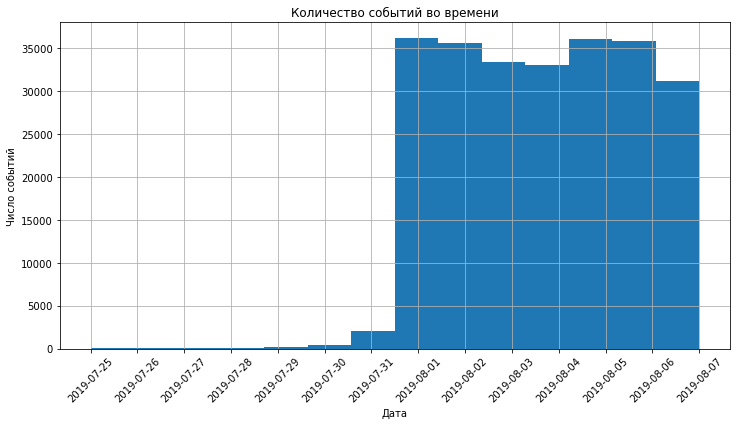

In [18]:
df['date'].hist(bins=14, figsize=(12,6))
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Число событий')
plt.title('Количество событий во времени')
plt.show()

По факту, самые полные данные имеются лишь за одну неделю — с 1 по 7 августа. Отсечем остальное.

In [19]:
df_new = df.query('date >= "2019-08-01"').reset_index(drop=True)
df_new

,event_name,user_id,event_timestamp,group,datetime,date
0,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
1,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
3,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
4,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
...,...,...,...,...,...,...
240882,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
240883,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
240884,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
240885,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


In [20]:
print(f"\
После отсечения лишнего потеряли {df['event_name'].count() - df_new['event_name'].count()} событий, \
или {round((df['event_name'].count() - df_new['event_name'].count())/df['event_name'].count()*100)}%.")

После отсечения лишнего потеряли 2826 событий, или 1%.


In [21]:
print(f"И {df['user_id'].nunique() - df_new['user_id'].nunique()} пользователей \
(или {round((df['user_id'].nunique() - df_new['user_id'].nunique())/df['user_id'].nunique()*100, 1)}%).")

И 17 пользователей (или 0.2%).


In [22]:
df_new.groupby('group')['user_id'].count().reset_index()

,group,user_id
0,246,79302
1,247,77022
2,248,84563


События по группам:
- 79425 в первой контрольной (246-й);
- 77147 во второй контрольной (247-й);
- 84726 в экспериментальной (248-й).

Определим, есть ли пользователи, которые попали более, чем в одну группу.

In [27]:
df_new.groupby('user_id')['group'].nunique().reset_index().query('group > 1')

,user_id,group


"Пересекающихся" пользователей нет.

## Изучение воронки событий

События, отсортированные по частоте.

In [28]:
df_new.groupby('event_name')['user_id'].count().sort_values(ascending=False).reset_index()

,event_name,user_id
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Число пользователей, которые совершали каждое из этих действий, и доля таковых от общего числа пользователей.

In [29]:
unique_users_per_event = df_new.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index()
unique_users_per_event['ratio'] = round(unique_users_per_event['user_id']/df_new['user_id'].nunique()*100, 2)
unique_users_per_event

,event_name,user_id,ratio
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Последовательность событий:

Главный экран (MainScreenAppear) --> Экран с выбором продуктов (OffersScreenAppear) --> Корзина (CartScreenAppear) --> Экран с соощением об успешной оплате (PaymentScreenSuccessful).

Страница с инструкцией не входит в обязательную цепочку действий, к тому же ее смотрит минимальное число пользователей — исключим ее из дальнейших расчетов.

In [ ]:
fig = go.Figure(
    go.Funnel(
        y=['Основной экран', 'Экран с выбором продуктов', 'Корзина', 'Успешная оплата'],
        x=unique_users_per_event['user_id'][:4],
        textinfo = "value+percent previous+percent initial",
        marker = {"color": ["silver", "tan", "lightsalmon", "deepskyblue"]}
    )
)
fig.update_layout(title='Воронка действий пользователей')
fig.show() 

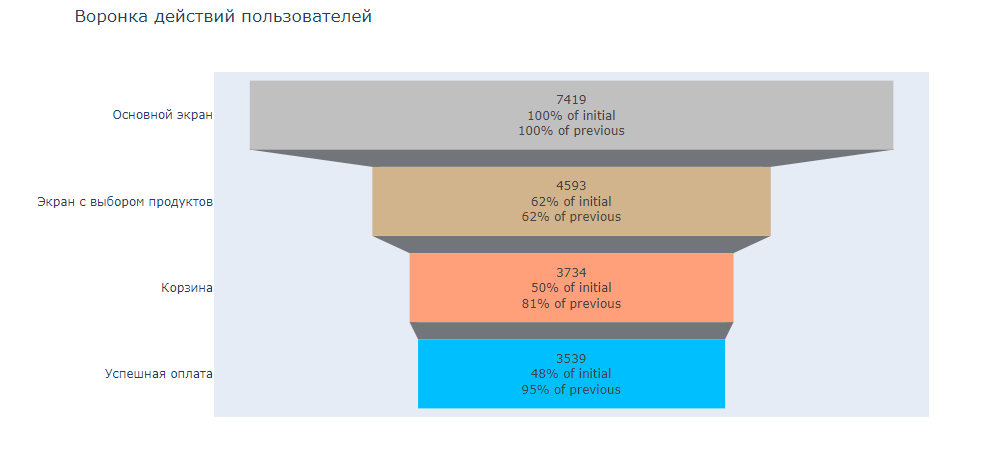

От первого шага до успешной оплаты (то есть конверсия из открывших приложение в покупателей) доходит почти половина пользователей (48%). Больше всего пользователей теряется на втором шаге — 38%. На третьем шаге "отваливаются" 19% пользователей относительно второго шага. На финальном четвертом — 5% относительно предыдущего.  

Судя по воронке, можно сделать вывод, что необходимо исследовать, почему в сравнении с другими шагами так много пользователей (38%) "отваливаются" на втором шаге. Возможно, людям, заходящим на главный экран, не нравится дизайн или они не могут сразу найти необходимые кнопки для продолжения покупок.

## Результаты эксперимента

Посмотрим, сколько уникальных пользователей оказались в группах.

In [31]:
df_wo_tutorial = df_new[df_new['event_name'] != 'Tutorial']
df_wo_tutorial.groupby('group')['user_id'].nunique().reset_index()

,group,user_id
0,246,2483
1,247,2512
2,248,2535


Различия незначительны, это один из признаков того, что система распределения работает правильно.

### АА-тест

Найдем, есть ли между группами статистически значимые отличия в долях пользователей, которые дошли до каждого из шагов воронки.

In [32]:
group_246 = (df_wo_tutorial[df_wo_tutorial['group'] == 246].groupby('event_name')['user_id']
                                                          .nunique().sort_values(ascending=False)
                                                          .reset_index())
group_246['users_total'] = df_wo_tutorial[df_wo_tutorial['group'] == 246]['user_id'].nunique()
group_246['ratio'] = round(group_246['user_id']/group_246['users_total']*100, 2)
group_246

,event_name,user_id,users_total,ratio
0,MainScreenAppear,2450,2483,98.67
1,OffersScreenAppear,1542,2483,62.10
2,CartScreenAppear,1266,2483,50.99
3,PaymentScreenSuccessful,1200,2483,48.33


In [33]:
group_247 = (df_wo_tutorial[df_wo_tutorial['group'] == 247].groupby('event_name')['user_id']
                                                          .nunique().sort_values(ascending=False)
                                                          .reset_index())
group_247['users_total'] = df_wo_tutorial[df_wo_tutorial['group'] == 247]['user_id'].nunique()
group_247['ratio'] = round(group_247['user_id']/group_247['users_total']*100, 2)
group_247

,event_name,user_id,users_total,ratio
0,MainScreenAppear,2476,2512,98.57
1,OffersScreenAppear,1520,2512,60.51
2,CartScreenAppear,1238,2512,49.28
3,PaymentScreenSuccessful,1158,2512,46.10


Создадим функцию для статистического сравнения групп.

In [34]:
def stat_significance(row1, row2):

    # пропорция успехов в первой группе:
    p1 = row1['user_id']/row1['users_total']

    # пропорция успехов во второй группе:
    p2 = row2['user_id']/row2['users_total']

    # пропорция успехов в комбинированном датасете:
    p_combined = (
                  (row1['user_id'] + row2['user_id']) /
                  (row1['users_total'] + row2['users_total'])
                 )

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/row1['users_total'] + 
                                                                     1/row2['users_total']))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print(f"Отвергаем нулевую гипотезу: между долями в категории {row1['event_name']} есть значимая разница")
    else:
        print(
            f"Не отвергаем нулевую гипотезу, нет оснований считать доли в категории {row1['event_name']} разными"
        ) 

При множественном сравнении для корректировки уровня статистической значимости применим метод Шидака, который рассчитывается по формуле 1-(1-alpha)^(1/(число проверок)). В данном случае у нас 4 сравнения между контрольными группами по 4 признакам.

Нулевая гипотеза по всем дальнейшим шестнадцати проверкам будет звучать так:
"Доля пользователей, которые совершили в первой группе определенный шаг, равна аналогичной доле во второй группе".

Альтернативная гипотеза:
"Доля пользователей, которые совершили в первой группе определенный шаг, не равна аналогичной доле во второй группе".

Внутри каждого блока сравнений поочередно сравниваем шаги MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful.

В ячейке ниже проверяем две контрольные группы (246 и 247) между собой.

In [35]:
alpha = 1 - (1 - 0.05)**(1/16)

for row in range(len(group_246)):
    stat_significance(group_246.loc[row], group_247.loc[row])
    print()

p-значение:  0.7526703436483038
Не отвергаем нулевую гипотезу, нет оснований считать доли в категории MainScreenAppear разными

p-значение:  0.24786096925282264
Не отвергаем нулевую гипотезу, нет оснований считать доли в категории OffersScreenAppear разными

p-значение:  0.22867643757335676
Не отвергаем нулевую гипотезу, нет оснований считать доли в категории CartScreenAppear разными

p-значение:  0.11446627829276612
Не отвергаем нулевую гипотезу, нет оснований считать доли в категории PaymentScreenSuccessful разными



По всем четырем шагам тест не показал статистически значимых раличий между двумя контрольными группами. Делаем вывод, что система распределения работает без сбоев.

### AB-тест

Теперь сравним экспериментальную группу с контрольными: сначала поочередно, затем с объединённой группой.

In [36]:
group_248 = (df_wo_tutorial[df_wo_tutorial['group'] == 248].groupby('event_name')['user_id']
                                                          .nunique().sort_values(ascending=False)
                                                          .reset_index())
group_248['users_total'] = df_wo_tutorial[df_wo_tutorial['group'] == 248]['user_id'].nunique()
group_248['ratio'] = round(group_248['user_id']/group_248['users_total']*100, 2)
group_248

,event_name,user_id,users_total,ratio
0,MainScreenAppear,2493,2535,98.34
1,OffersScreenAppear,1531,2535,60.39
2,CartScreenAppear,1230,2535,48.52
3,PaymentScreenSuccessful,1181,2535,46.59


Ниже сравниваем экспериментальную группу (248) с первой контрольной (246).

In [37]:
alpha = 1 - (1 - 0.05)**(1/16)

for row in range(len(group_246)):
    stat_significance(group_246.loc[row], group_248.loc[row])
    print()

p-значение:  0.3387114076159288
Не отвергаем нулевую гипотезу, нет оснований считать доли в категории MainScreenAppear разными

p-значение:  0.21442476639710506
Не отвергаем нулевую гипотезу, нет оснований считать доли в категории OffersScreenAppear разными

p-значение:  0.08067367598823139
Не отвергаем нулевую гипотезу, нет оснований считать доли в категории CartScreenAppear разными

p-значение:  0.21693033984516674
Не отвергаем нулевую гипотезу, нет оснований считать доли в категории PaymentScreenSuccessful разными



Теперь — экспериментальную группу (248) со второй контрольной (247).

In [38]:
alpha = 1 - (1 - 0.05)**(1/16)

for row in range(len(group_247)):
    stat_significance(group_247.loc[row], group_248.loc[row])
    print()

p-значение:  0.5194964354051703
Не отвергаем нулевую гипотезу, нет оснований считать доли в категории MainScreenAppear разными

p-значение:  0.9333751305879443
Не отвергаем нулевую гипотезу, нет оснований считать доли в категории OffersScreenAppear разными

p-значение:  0.5878284605111943
Не отвергаем нулевую гипотезу, нет оснований считать доли в категории CartScreenAppear разными

p-значение:  0.7275718682261119
Не отвергаем нулевую гипотезу, нет оснований считать доли в категории PaymentScreenSuccessful разными



In [39]:
group_246_247_combined = (df_wo_tutorial[df_wo_tutorial['group'] != 248].groupby('event_name')['user_id']
                                                          .nunique().sort_values(ascending=False)
                                                          .reset_index())
group_246_247_combined['users_total'] = df_wo_tutorial[df_wo_tutorial['group'] != 248]['user_id'].nunique()
group_246_247_combined['ratio'] = round(group_246_247_combined['user_id']/
                                        group_246_247_combined['users_total']*100, 2)
group_246_247_combined

,event_name,user_id,users_total,ratio
0,MainScreenAppear,4926,4995,98.62
1,OffersScreenAppear,3062,4995,61.30
2,CartScreenAppear,2504,4995,50.13
3,PaymentScreenSuccessful,2358,4995,47.21


И наконец — экспериментальную группу (248) с объединенной контрольной (246+247).

In [40]:
alpha = 1 - (1 - 0.05)**(1/16)

for row in range(len(group_247)):
    stat_significance(group_248.loc[row], group_246_247_combined.loc[row])
    print()

p-значение:  0.3486684291093256
Не отвергаем нулевую гипотезу, нет оснований считать доли в категории MainScreenAppear разными

p-значение:  0.44582745409482394
Не отвергаем нулевую гипотезу, нет оснований считать доли в категории OffersScreenAppear разными

p-значение:  0.18683558686831558
Не отвергаем нулевую гипотезу, нет оснований считать доли в категории CartScreenAppear разными

p-значение:  0.6107918742187335
Не отвергаем нулевую гипотезу, нет оснований считать доли в категории PaymentScreenSuccessful разными



Ни в одной из серий сравнений тест не показал статистически значимых различий. Значит, новый шрифт никак не повлиял на поведение пользователей.

## Выводы

Изучив логи с поведением пользователей приложения для продажи продуктов питания, мы узнали, что:

- В лог вносятся пять основных событий: главный экран (MainScreenAppear), экран с выбором продуктов (OffersScreenAppear), корзина (CartScreenAppear), экран с сообщением об успешной оплате (PaymentScreenSuccessful), страница с инструкцией (Tutorial). Инструкция — необязательное и малозначимое действие, поэтому мы его не учитывали в исследовании.

- Число уникальных пользователей во всем логе — 7551. Среднее число событий на пользователя — более 32. Медианное значение — 20.

- Эксперимент проводился с 25 июля по 7 августа 2019 года, однако, по факту, самые полные данные имеются лишь за одну неделю — с 1 по 7 августа.

- После отсечения ненужных данных число событий распределилось по группам так: 79425 в первой контрольной (246-й), 77147 во второй контрольной (247-й), 84726 в экспериментальной (248-й). "Пересекающихся" пользователей нет. Различия между группами по числу уникальных пользователей незначительны — все это признаки того, что система распределения работает правильно.

- От первого шага до успешной оплаты доходит почти половина пользователей (48%). Больше всего пользователей теряется на втором шаге — 38%.

- По долям пользователей на всех четырех шагах A/A-тест не показал статистически значимых раличий между двумя контрольными группами. Значит, система распределения работает без сбоев.

- Ни в одной из серий сравнений A/B-тест так же не показал статистически значимых различий.

## Рекомендации

- Исследовать, почему большое количество пользователей (более трети) отваливаются после первого же шага.

- Отказаться от выкатки нового шрифта в приложении, так как это не повлияет на поведение пользователей.